# Import

In [1]:
## Library for data processing
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pycaret.classification import *

## Pipeline and Algorithm
# from imblearn.pipeline import Pipeline
# from pandas_profiling import ProfileReport
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer

## from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import KNNImputer, SimpleImputer

## Logistic Regression
from sklearn.linear_model import LogisticRegression

## Metrics Evaluation
from sklearn.metrics import (
    average_precision_score,
    classification_report,
    roc_auc_score,
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

# from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, StandardScaler

## Imbalance
# from imblearn.over_sampling import SMOTE


# from sklearn.tree import DecisionTreeClassifier
# from xgboost.sklearn import XGBClassifier

warnings.filterwarnings("ignore")

In [3]:
train_raw = pd.read_csv("transactions.csv")
# test_raw = pd.read_csv("test.csv")

In [4]:
train_raw.columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'isFraud', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch'],
      dtype='object')

In [5]:
train_raw.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,isFraud,currentBalance,cardPresent,expirationDateKeyInMatch
0,733493772,733493772,5000,5000.00,2016-01-08T19:04:50,111.33,Lyft,US,US,5.0,...,3/8/2014,3/8/2014,492,492,9184,PURCHASE,True,0.00,False,False
1,733493772,733493772,5000,4888.67,2016-01-09T22:32:39,24.75,Uber,US,US,9.0,...,3/8/2014,3/8/2014,492,492,9184,PURCHASE,False,111.33,False,False
2,733493772,733493772,5000,4863.92,2016-01-11T13:36:55,187.40,Lyft,US,US,5.0,...,3/8/2014,3/8/2014,492,492,9184,PURCHASE,False,136.08,False,False
3,733493772,733493772,5000,4676.52,2016-01-11T22:47:46,227.34,Lyft,US,US,2.0,...,3/8/2014,3/8/2014,492,492,9184,PURCHASE,True,323.48,False,False
4,733493772,733493772,5000,4449.18,2016-01-16T01:41:11,0.00,Lyft,US,US,2.0,...,3/8/2014,3/8/2014,492,492,9184,ADDRESS_VERIFICATION,False,550.82,False,False


# Deksripsi Variabel

* `accountNumber`
* `customerId`
* `creditLimit`
* `availableMoney`
* `transactionDateTime`
* `transactionAmount`
* `merchantName`
* `acqCountry`
* `merchantCountryCode`
* `posEntryMode`
* `posConditionCode`
* `merchantCategoryCode`
* `currentExpDate`
* `accountOpenDate`
* `dateOfLastAddressChange`
* `cardCVV`
* `enteredCVV`
* `cardLast4Digits`
* `transactionType`
* `isFraud`
* `currentBalance`
* `cardPresent`
* `expirationDateKeyInMatch`

# Pandas Profiling

In [5]:
# profile = ProfileReport(train_raw, title="Pandas Profiling Report")

In [6]:
# profile.to_widgets()

# EDA
## Check Missing Value

In [6]:
def check_null(df):
    null_df = pd.DataFrame(df.isnull().sum() columns=["missing"])
    null_df = null_df.reset_index()
    null_df["total"] = len(df)
    null_df["type"] = df.dtypes
    null_df["percent"] = null_df.missing / len(df) * 100
    return null_df[null_df.missing.gt(0)]

In [7]:
check_null(train_raw)

,index,missing,total,type,percent
7,acqCountry,3913,641914,NaN,0.609583
8,merchantCountryCode,624,641914,NaN,0.097209
9,posEntryMode,3345,641914,NaN,0.521098
10,posConditionCode,287,641914,NaN,0.044710
18,transactionType,589,641914,NaN,0.091757


## Check unique value

In [8]:
train_raw.apply(lambda col: ", ".join(map(str, col.unique())))

accountNumber               733493772, 578754168, 664577296, 550655231, 96...
customerId                  733493772, 578754168, 664577296, 550655231, 96...
creditLimit                 5000, 7500, 250, 20000, 500, 50000, 2500, 1500...
availableMoney              5000.0, 4888.67, 4863.92, 4676.52, 4449.18, 44...
transactionDateTime         2016-01-08T19:04:50, 2016-01-09T22:32:39, 2016...
transactionAmount           111.33, 24.75, 187.4, 227.34, 0.0, 9.8, 247.99...
merchantName                Lyft, Uber, Fresh eCards, Universe Massage #95...
acqCountry                                              US, nan, PR, MEX, CAN
merchantCountryCode                                     US, PR, MEX, nan, CAN
posEntryMode                                   5.0, 9.0, 2.0, 90.0, nan, 80.0
posConditionCode                                          1.0, 8.0, 99.0, nan
merchantCategoryCode        rideshare, online_gifts, personal care, fastfo...
currentExpDate              1/4/2020, 1/6/2023, 1/12/2027, 1/9/2

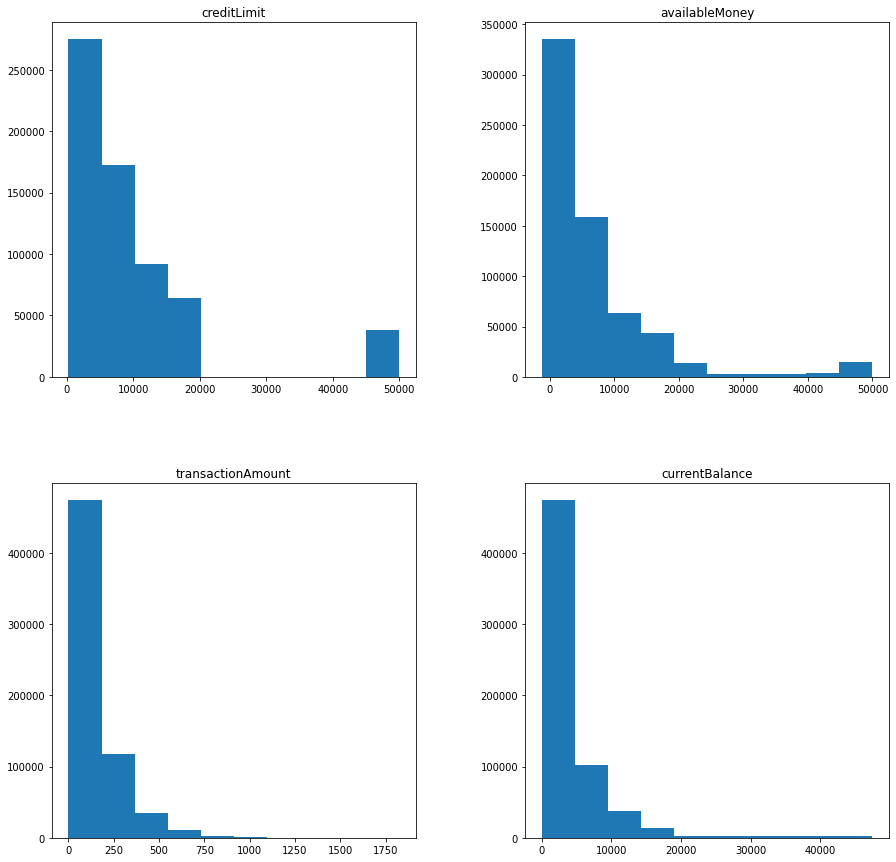

In [16]:
train_raw[
    [
        "creditLimit",
        "availableMoney",
        "transactionAmount",
        "currentBalance"
    ]
].hist(figsize=(15, 15), grid=False);

## Correlation

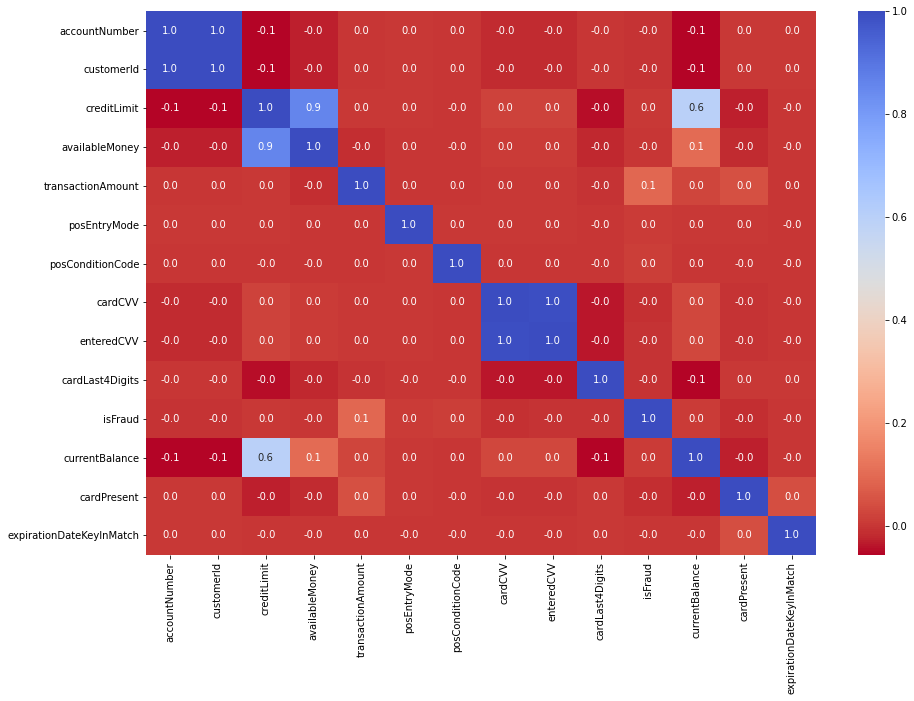

In [17]:
plt.figure(figsize=(15, 10))
sns.heatmap(train_raw.corr(), cmap=plt.cm.coolwarm_r, annot=True, fmt=".1f");

In [18]:
train_raw.corr().unstack().sort_values(ascending=False).drop_duplicates().head(10)

accountNumber             accountNumber        1.000000
cardCVV                   enteredCVV           0.995397
availableMoney            creditLimit          0.856440
creditLimit               currentBalance       0.598413
currentBalance            availableMoney       0.098895
isFraud                   transactionAmount    0.088708
transactionAmount         cardPresent          0.043289
expirationDateKeyInMatch  cardPresent          0.041320
enteredCVV                currentBalance       0.027195
cardCVV                   currentBalance       0.027160
dtype: float64

# Data Cleaning

In [19]:
train_df = train_raw.copy()

## Fillna

In [30]:
train_df.fillna(0, inplace=True)

# ECDF

https://www.kaggle.com/hervind/apakah-label-nya-masih-random

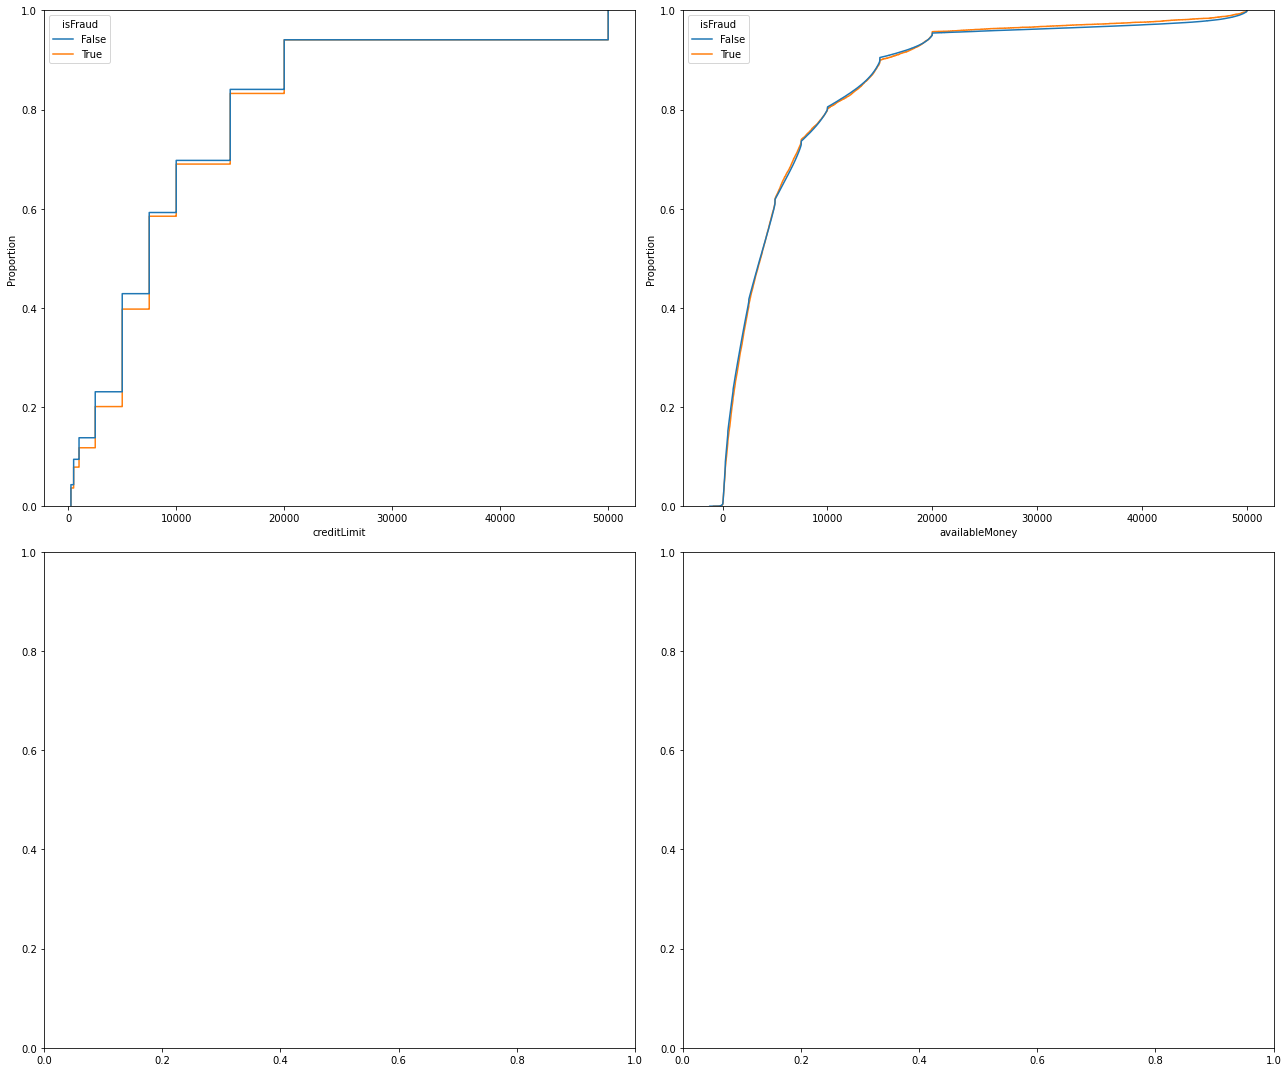

In [28]:
target_col = "isFraud"
feature_cols = train_df.drop(target_col, axis=1).columns

displayed_cols = [
    "creditLimit",
    "availableMoney",
]

fig, ax = plt.subplots(2, 2, figsize=(18, 15))

for col_index, col in enumerate(displayed_cols):
    i = int(col_index / 2)
    j = col_index % 2
    sns.ecdfplot(ax=ax[i, j], data=train_df, x=col, hue=target_col)

plt.tight_layout()

In [29]:
dummy_df = train_df.copy()
dummy_df["dummy_col"] = 1
df_0 = dummy_df.loc[dummy_df[target_col] == 0]
df_1 = dummy_df.loc[dummy_df[target_col] == 1]


def get_cumsum_mae(col_inspected):
    cumsum_0 = df_0.groupby([col_inspected])[["dummy_col"]].count().cumsum()
    cumsum_0 = (cumsum_0 / len(df_0)).reset_index()
    cumsum_1 = df_1.groupby([col_inspected])[["dummy_col"]].count().cumsum()
    cumsum_1 = (cumsum_1 / len(df_1)).reset_index()

    cumsum_compare = (
        cumsum_0.merge(cumsum_1, how="outer", on=col_inspected, suffixes=("_0", "_1"))
        .sort_values(col_inspected)
        .reset_index(drop=True)
        .fillna(method="ffill")
        .fillna(0)
    )
    return np.mean(
        np.abs(cumsum_compare["dummy_col_0"] - cumsum_compare["dummy_col_1"])
    )


df_features = pd.DataFrame()
df_features["feature_name"] = feature_cols
df_features["cumsum_diff_mean"] = df_features["feature_name"].map(get_cumsum_mae)
df_features.sort_values("cumsum_diff_mean", ascending=False)

,feature_name,cumsum_diff_mean
5,transactionAmount,0.145599
9,posEntryMode,0.055176
19,currentBalance,0.029844
20,cardPresent,0.028359
11,merchantCategoryCode,0.026952
4,transactionDateTime,0.021112
6,merchantName,0.020717
15,cardCVV,0.018132
1,customerId,0.017072
0,accountNumber,0.017072


# Feature Engineering

# Modelling Exp 1: PyCaret

## Feature Selection

In [41]:
# ignore_features = ["transactionAmount", "posEntryMode", "currentBalance", "cardPresent", "merchantCategoryCode"]
# train_final = train_df.drop(ignore_features, axis=1)

## Encoding

In [42]:
# train_final = pd.get_dummies(train_final)
# test_final = pd.get_dummies(test_final)
# label_final = train_final["Best Performance"]
# train_final = train_final.drop("Best Performance", axis=1)

In [30]:
print(train_df.columns)

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'isFraud', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch'],
      dtype='object')


## Try pycaret

In [50]:
# from pycaret.datasets import get_data

# juice = get_data("juice")
# juice.head()

In [51]:
# from pycaret.classification import *

# exp_name = setup(data=juice, target="Purchase")

# best_model = compare_models()

## Try Real Data

In [ ]:
exp_name = setup(
    data=train_df,
    target="isFraud",
#     categorical_features=["gender", "age", "number_of_dependences"],
#     numeric_features=[
#         "year_graduated",
#         "job_duration_from_training",
#         "assign_of_otherposition",
#         "total_leave",
#         "total_rotation",
#     ],
)

best_model = compare_models(sort="AUC")

IntProgress(value=0, description='Processing: ', max=13)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:43:12
Status,. . . . . . . . . . . . . . . . . .,Preparing Data for Modeling
ETC,. . . . . . . . . . . . . . . . . .,Calculating ETC


Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
accountNumber,Numeric
customerId,Numeric
creditLimit,Categorical
availableMoney,Numeric
transactionDateTime,Date
transactionAmount,Numeric
merchantName,Categorical
acqCountry,Categorical
merchantCountryCode,Categorical
posEntryMode,Categorical


In [53]:
ada = create_model("ada")
ada = finalize_model(ada)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8566,0.6024,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.8579,0.5376,0.0089,1.0000,0.0177,0.0152,0.0875
2,0.8553,0.5495,0.0000,0.0000,0.0000,-0.0025,-0.0147
3,0.8566,0.5565,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.8553,0.5171,0.0089,0.3333,0.0174,0.0100,0.0337
5,0.8528,0.4746,0.0000,0.0000,0.0000,-0.0051,-0.0208
6,0.8515,0.5575,0.0000,0.0000,0.0000,-0.0075,-0.0255
7,0.8564,0.5089,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.8564,0.5553,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.8564,0.5714,0.0000,0.0000,0.0000,0.0000,0.0000


In [54]:
prep = get_config("prep_pipe")

In [55]:
prep

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=['gender', 'age',
                                                            'number_of_dependences'],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=['year_graduated',
                                                          'job_duration_from_training',
                                                          'assign_of_otherposition',
                                                          'total_leave',
                                                          'total_rotation'],
                                      target='Best Performance',...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_

In [56]:
ada

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=4694)

In [57]:
pd.DataFrame(ada.predict_proba(prep.transform(test_final)))

,0,1
0,0.510774,0.489226
1,0.507061,0.492939
2,0.508459,0.491541
3,0.510666,0.489334
4,0.507157,0.492843
...,...,...
5995,0.510430,0.489570
5996,0.510065,0.489935
5997,0.507768,0.492232
5998,0.513638,0.486362


In [58]:
predict_model(ada, data=test_final, raw_score=True)

,job_level,job_duration_in_current_job_level,person_level,job_duration_in_current_person_level,job_duration_in_current_branch,Employee_type,gender,age,marital_status_maried(Y/N),number_of_dependences,...,year_graduated,job_duration_from_training,assign_of_otherposition,Last_achievement_%,Achievement_above_100%_during3quartal,total_leave,total_rotation,Label,Score_0,Score_1
0,JG04,1.256981,PG03,1.256981,0.707107,RM_type_A,1,33,N,0,...,2009,6,6,84.02,0.0,10,6,0,0.5108,0.4892
1,JG04,1.224745,PG03,1.224745,1.256981,RM_type_B,2,30,N,0,...,2014,2,0,63.74,0.0,1,4,0,0.5071,0.4929
2,JG04,0.500000,PG03,0.500000,1.081665,RM_type_A,2,32,Y,1,...,2011,4,0,88.19,1.0,3,4,0,0.5085,0.4915
3,JG04,1.256981,PG03,1.256981,1.802776,RM_type_A,2,31,Y,1,...,2014,3,0,25.94,0.0,3,4,0,0.5107,0.4893
4,JG04,1.352775,PG03,1.352775,1.224745,RM_type_B,1,36,Y,0,...,2007,5,0,82.32,0.0,3,5,0,0.5072,0.4928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,JG04,1.292285,PG03,1.292285,0.707107,RM_type_B,2,33,Y,0,...,2015,2,0,58.60,0.0,4,4,0,0.5104,0.4896
5996,JG04,1.352775,PG03,1.352775,1.581139,RM_type_A,2,32,Y,1,...,2011,5,7,90.64,3.0,3,5,0,0.5101,0.4899
5997,JG04,1.385641,PG03,1.385641,1.224745,RM_type_A,2,30,Y,0,...,2013,3,0,13.02,0.0,16,5,0,0.5078,0.4922
5998,JG05,1.385641,PG05,1.385641,0.648074,RM_type_A,2,41,Y,2,...,2003,14,8,82.26,0.0,2,13,0,0.5136,0.4864


In [60]:
gbc = create_model("gbc")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8553,0.5821,0.0089,0.3333,0.0174,0.0100,0.0337
1,0.8528,0.5508,0.0000,0.0000,0.0000,-0.0075,-0.0254
2,0.8540,0.5231,0.0000,0.0000,0.0000,-0.0051,-0.0207
3,0.8566,0.5728,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.8553,0.5308,0.0000,0.0000,0.0000,-0.0025,-0.0147
5,0.8528,0.4792,0.0000,0.0000,0.0000,-0.0051,-0.0208
6,0.8502,0.5481,0.0000,0.0000,0.0000,-0.0100,-0.0295
7,0.8551,0.5662,0.0000,0.0000,0.0000,-0.0025,-0.0147
8,0.8551,0.5895,0.0000,0.0000,0.0000,-0.0025,-0.0147
9,0.8551,0.5669,0.0000,0.0000,0.0000,-0.0025,-0.0147


In [61]:
gbc

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=4694, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

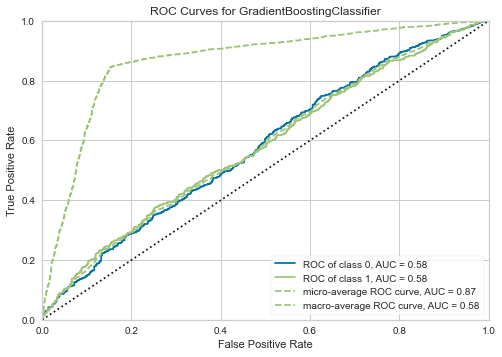

In [62]:
plot_model(gbc, plot="auc")

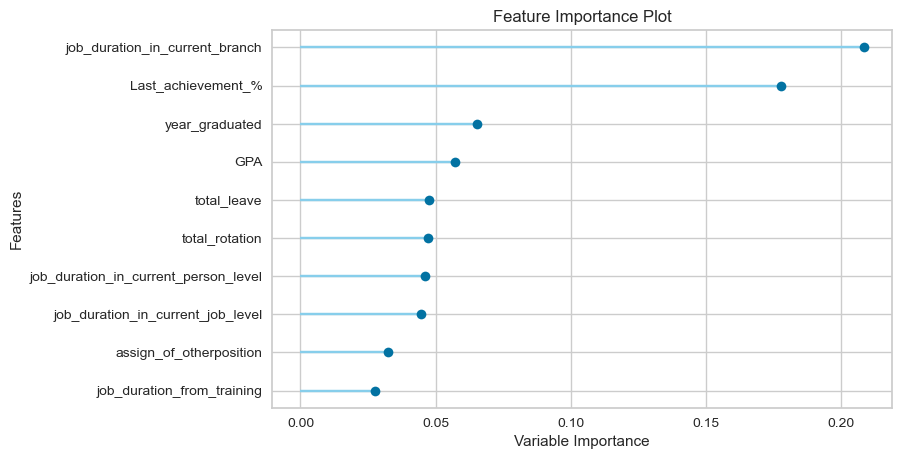

In [63]:
plot_model(gbc, plot="feature")

In [64]:
# interpret_model(gbc)

In [65]:
final_gbc = finalize_model(gbc)

In [66]:
test_predictions = predict_model(final_gbc, data=test_final, raw_score=True)

In [67]:
test_predictions.Score_1.describe()

count    6000.000000
mean        0.147400
std         0.051953
min         0.039700
25%         0.119100
50%         0.138000
75%         0.162700
max         0.754000
Name: Score_1, dtype: float64

In [68]:
submission = pd.read_csv("sample_submission.csv")
submission.head()

,index,Best Performance
0,0,0.131028
1,1,0.379354
2,2,0.031798
3,3,0.285220
4,4,0.848732


In [69]:
submission["Best Performance"] = test_predictions.Score_1
submission

,index,Best Performance
0,0,0.1251
1,1,0.1754
2,2,0.2377
3,3,0.0958
4,4,0.1534
...,...,...
5995,5995,0.1144
5996,5996,0.1082
5997,5997,0.1843
5998,5998,0.0990


In [70]:
submission.to_csv("submission_om1.csv", index=False)

In [62]:
# https://dacon.io/codeshare/1829?dtype=recent

In [69]:
LGBM = create_model("lightgbm")

LGBM.predict_proba(test_final)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8528,0.5427,0.0174,0.5000,0.0336,0.0240,0.0714
1,0.8528,0.5488,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.8528,0.5414,0.0261,0.5000,0.0496,0.0355,0.0876
3,0.8515,0.5856,0.0087,0.3333,0.0169,0.0095,0.0326
4,0.8502,0.5446,0.0174,0.3333,0.0331,0.0187,0.0462
5,0.8489,0.5181,0.0088,0.1667,0.0167,0.0021,0.0052
6,0.8553,0.6351,0.0175,0.6667,0.0342,0.0269,0.0916
7,0.8513,0.5507,0.0000,0.0000,0.0000,-0.0051,-0.0210
8,0.8526,0.5681,0.0088,0.3333,0.0171,0.0097,0.0329
9,0.8526,0.5561,0.0000,0.0000,0.0000,-0.0025,-0.0148


ValueError: Number of features of the model must match the input. Model n_features_ is 76 and input n_features is 37 

# Modelling Exp 2

## Split

## One Hot

In [ ]:
# """
# 'job_level', 'job_duration_in_current_job_level', 'person_level',
# 'job_duration_in_current_person_level',
# 'job_duration_in_current_branch', 'Employee_type', 'gender', 'age',
# 'marital_status_maried(Y/N)', 'number_of_dependences',
# 'Education_level', 'GPA', 'year_graduated',
# 'job_duration_from_training', 'branch_rotation', 'job_rotation',
# 'assign_of_otherposition', 'annual leave', 'sick_leaves',
# 'Last_achievement_%', 'Achievement_above_100%_during3quartal',
# 'Best Performance', 'total_leave', 'total_rotation'

# ['job_duration_in_current_person_level', 'person_level',  'GPA', 'age', 'Last_achievement_%', 'Achievement_above_100%_during3quartal']

# """


# oh_cols = [
#     "job_level",
#     "person_level",
#     "Employee_type",
#     "Education_level",
#     "gender",
#     "marital_status_maried(Y/N)",
# ]

# ordinal_cols = ["job_level", "person_level", "Education_level"]

# numeric_var = [
#     "job_duration_in_current_job_level",
#     "job_duration_in_current_person_level",
#     "job_duration_in_current_branch",
#     "age",
#     "number_of_dependences",
#     "GPA",
#     "branch_rotation",
#     "job_rotation",
#     "assign_of_otherposition",
#     "annual leave",
#     "sick_leaves",
#     "Last_achievement_%",
#     "Achievement_above_100%_during3quartal",
# ]
# one_hot_encoder_pipeline = Pipeline(
#     [("one hot encoder", OneHotEncoder(handle_unknown="ignore"))]
# )

# numerical_pipeline = Pipeline(
#     [
#         ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
#         ("bin", KBinsDiscretizer(encode="onehot", strategy="kmeans", n_bins=5)),
#     ]
# )

# transformer = ColumnTransformer(
#     [
#         ("one hot encoder", one_hot_encoder_pipeline, oh_cols),
#         ("numerical_pipeline", numerical_pipeline, numeric_var),
#     ]
# )

In [ ]:
var_x = numeric_var + oh_cols

X = train[var_x]
X_sub = test[var_x]
y = train["Best Performance"]

## Fitting

In [ ]:
transformer.fit(X)  # fitting only for feature namse
one_hot_result = list(
    transformer.transformers_[0][1]["one hot encoder"].get_feature_names()
)
features = one_hot_result + numeric_var

In [ ]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, stratify=y, test_size=2000, random_state=2021
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, stratify=y_trainval, test_size=2000, random_state=2021
)

In [ ]:
model = LogisticRegression(solver="newton-cg")
select = SelectFromModel(model, threshold="median")

estimator = Pipeline(
    [
        ("preprocess", transformer),
        #                       ('select',select),
        ("clf", model),
    ]
)

In [ ]:
estimator.fit(X_train, y_train)

In [ ]:
y_prob_test = estimator.predict_proba(X_test)[:, 1]
# y_pred_test = np.where(y_prob_test > 0.13, 1, 0)

print("auc", roc_auc_score(y_test, y_prob_test), "\n")
# print("classification report \n", classification_report(y_test, y_pred_test))

In [ ]:
y_prob_test = estimator.predict_proba(X_train)[:, 1]
# y_pred_test = np.where(y_prob_test > 0.13, 1, 0)

print("auc", roc_auc_score(y_train, y_prob_test), "\n")
# print("classification report \n", classification_report(y_train, y_pred_test))

# Prediction

In [ ]:
estimator.fit(X, y)
y_pred_sub = estimator.predict_proba(X_sub)[:, 1]
test["Best Performance"] = y_pred_sub
submission = test[["Best Performance"]]
submission.reset_index().to_csv("submission.csv", index=False)

In [ ]:
submission.describe()

# Catatan

1. Kompetisi

https://www.kaggle.com/kiniekurniakusuma/eda-similarity-check-people-analysis-bri

data similar dengan sebelumnya


1. submission (1).csv 0.535004